# Find Multiple Mutations in Cis

For a user specified gene, this notebook finds if there are multiple types of mutations 

In [1]:
import cptac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plot_utils as p
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import CPTAC data
en = cptac.Endometrial()
hn = cptac.Hnscc()
l = cptac.Luad()
o = cptac.Ovarian()
c = cptac.Ccrcc()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()
ls = cptac.Lscc()

In [20]:
def figure1_plot_mutations(cis_gene, dflist = None, names_of_df=None, title=None, save_to_path=None):
    number_of_df = len(dflist)

    allLabels = []
    for df in dflist:
        #get the labels for each and make a combined label that they'll all use
        mutation = df["All_Mutations_"+cis_gene]
        labels = list(set(mutation))

        allLabels.append(labels)

    flat_list = [item for sublist in allLabels for item in sublist]
    all_labels = list(set(flat_list))
    all_labels.sort()
    allLabels = all_labels

#     For each df, add na to their labels if it doesn't exist in all_labels
    labels_for_each_df = []
    frequencies_for_each_df = []
    for df in dflist:
        mutation = df["All_Mutations_"+cis_gene].tolist()
        mutationlist = list(set(mutation))
        mutationlist.sort()
        ordered_mut_list = []
        match = True
        mutPosition = 0

        for position in range(len(all_labels)):
            try:

                if mutationlist[mutPosition] == all_labels[position]:
                    ordered_mut_list.append(mutationlist[mutPosition])
                    mutPosition += 1

                else:
                    ordered_mut_list.append("na")

            except IndexError:
                ordered_mut_list.append("na")


        labels_for_each_df.append(ordered_mut_list)

        #get the freq of each mutation type
        freq = []
        for mutation_type in ordered_mut_list:
            freq.append(mutation.count(mutation_type))

        PercentFreq = [x*100 / sum(freq) for x in freq]
        frequencies_for_each_df.append(PercentFreq)


    #Now plot it using arrays
    width = 0.1
    x = np.arange(len(allLabels))
    a4_dims = (14, 10) #dimensions for bigger plot
    fig, ax = plt.subplots(figsize=a4_dims)
    for position in range(0, number_of_df):
        r = ax.bar(x+(width*position), frequencies_for_each_df[position], width,label=names_of_df[position], alpha=.5, linewidth=0)

    font_size = 14

    ax.set_ylabel('Percent Sample', size = font_size)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(allLabels)
    ax.legend()
    ax.set_xticklabels(allLabels, size = 16)
    ax.set_ylim(0,100)
    ax.legend(prop={'size': font_size})
    ax.yaxis.set_tick_params(labelsize=font_size)


    plt.setp(ax.get_xticklabels(),rotation= 90)
    plt.tight_layout()
    if save_to_path == None:
        plt.savefig("step_1.png",dpi = 300)
    else:
        plt.savefig(save_to_path)

    plt.show()

In [5]:
def mult_mutations(mut, list_in):
    if list_in.count(mut) > 1:
        name = mut
    while mut in list_in: list_in.remove(mut)
    
    for e in list_in:
        name = e+', '+name
        
    name_list = name.split(', ') # return to list in case there are more multiple mutations
    return name_list
    

In [8]:
def find_multi_cis_mut(cancer_obj,cis_gene):
    #Get all somatic mutations 
    mutations = cancer_obj.get_somatic_mutation()
    #get just somatic mutations for cis_gene
    cis_mut = mutations[mutations.Gene == cis_gene]
    cis_mut = cis_mut[["Mutation"]]
    
    #simplfy names 
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Missense_Mutation', 'Missense', inplace = True) # replaces when false
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Del', 'Missense', inplace = True)
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'In_Frame_Ins', 'Missense', inplace = True)

    # replace colon different mutation names
    colon_mut_names = {'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
                   'frameshift substitution': 'Truncation', 'stopgain': 'Truncation', 'stoploss': 'Truncation',
                  'nonframeshift deletion': 'Missense', 'nonframeshift insertion': 'Missense', 
                   'nonframeshift substitution': 'Missense', 'nonsynonymous SNV': 'Missense'}
    cis_mut = cis_mut.replace(colon_mut_names)
    
    #group Truncation
    cis_mut["Mutation"].where(cis_mut["Mutation"] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Del', 'Truncation', inplace = True)
    cis_mut["Mutation"].where(cis_mut['Mutation'] != 'Frame_Shift_Ins', 'Truncation', inplace = True)
    
    
    # Multiple somatic mutations are indicated using multiple rows with the same patient ids.
    # We will group the rows by patient ids and then relabel the columns that have multiple mutations 
    cis_mut = cis_mut.groupby(level=['Patient_ID'], sort=False).agg( ','.join)
    
    # Create multiple mutation label for each multiple mutation in a sample
    cis_mut = cis_mut[['Mutation']].apply(lambda x: x.str.split(',')) # put in list to use mult_mutations function
    possible_mutations = ['Truncation', 'Missense', 'Indel', 'Splice_Site']
    for mut in possible_mutations:
        cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: mult_mutations(mut, x) if x.count(mut) > 1 else x)
    # change list to string
    delim = ', '
    cis_mut.Mutation = cis_mut.Mutation.apply(lambda x: delim.join(x) if type(x) is list else x)

    #get CNV mutations 
    mut_copy_num = cancer_obj.get_genotype_all_vars(cis_gene, mutations_filter = ["Deletion","Amplification","Wildtype_Tumor"])
    mut_copy_num["Mutation"].where(mut_copy_num['Mutation'] != 'No_Mutation', 'Wildtype_Tumor', inplace = True) # change No_Mutation to Wildtype_Tumor
    mut_copy_num = mut_copy_num[mut_copy_num['Mutation'].isin(["Deletion","Amplification","Wildtype_Tumor"])]
    mut_copy_num = mut_copy_num.rename(columns={'Mutation': 'CNV_Mutation'})
    mut_copy_num = mut_copy_num["CNV_Mutation"]
    mutations = pd.merge(mut_copy_num, cis_mut, on="Patient_ID", how = "outer")
    
    # If mutation column is NaN replace with value in Mutation_Copy_Num
    mutations['Mutation'] = mutations.apply(
        lambda row: row['CNV_Mutation'] if pd.isnull(row['Mutation']) else row['Mutation'], axis=1)
   # mutations = mutations.CNV_Mutation.fillna('', inplace=True)
    #Make column All_Mutation which is a list of all mutations 
    mutations = mutations.replace(np.nan, '', regex=True)
    mutations['All_Mutations'] = mutations.apply(
        lambda row: row["CNV_Mutation"] + ", " + row["Mutation"] if (row["CNV_Mutation"] != row["Mutation"] and row["CNV_Mutation"] != "") else row['Mutation'], axis=1)
    mutations = mutations.rename(columns={'All_Mutations': 'All_Mutations_' + cis_gene})
    
    del_only = mutations.loc[mutations['All_Mutations_'+cis_gene] == 'Deletion']
    trunc_only = mutations.loc[mutations['All_Mutations_'+cis_gene] == 'Truncation']
    wt_only = mutations.loc[mutations['All_Mutations_'+cis_gene].str.contains('Wildtype_Tumor')]
    df = del_only.append(trunc_only)
    mut_wt = df.append(wt_only)
    
    return mut_wt

In [9]:
#Call function to create dataframe with all mutations 
cis_gene = "PTEN"

endo = find_multi_cis_mut(en, cis_gene)
gbm = find_multi_cis_mut(g, cis_gene)
hnscc = find_multi_cis_mut(hn, cis_gene)
ovar = find_multi_cis_mut(o, cis_gene)
cc = find_multi_cis_mut(c, cis_gene)
colon = find_multi_cis_mut(col, cis_gene)
ld = find_multi_cis_mut(l, cis_gene)
brca = find_multi_cis_mut(b, cis_gene)
lscc = find_multi_cis_mut(ls, cis_gene)


In [10]:
gbm.

,CNV_Mutation,Mutation,All_Mutations_PTEN
Patient_ID,,,
C3L-00365,Deletion,Deletion,Deletion
C3L-01040,Deletion,Deletion,Deletion
C3L-01045,Deletion,Deletion,Deletion
C3L-01048,Deletion,Deletion,Deletion
C3L-01149,Deletion,Deletion,Deletion
...,...,...,...
C3N-02783,Wildtype_Tumor,Wildtype_Tumor,Wildtype_Tumor
C3N-02785,Wildtype_Tumor,Wildtype_Tumor,Wildtype_Tumor
C3N-03088,Wildtype_Tumor,Wildtype_Tumor,Wildtype_Tumor


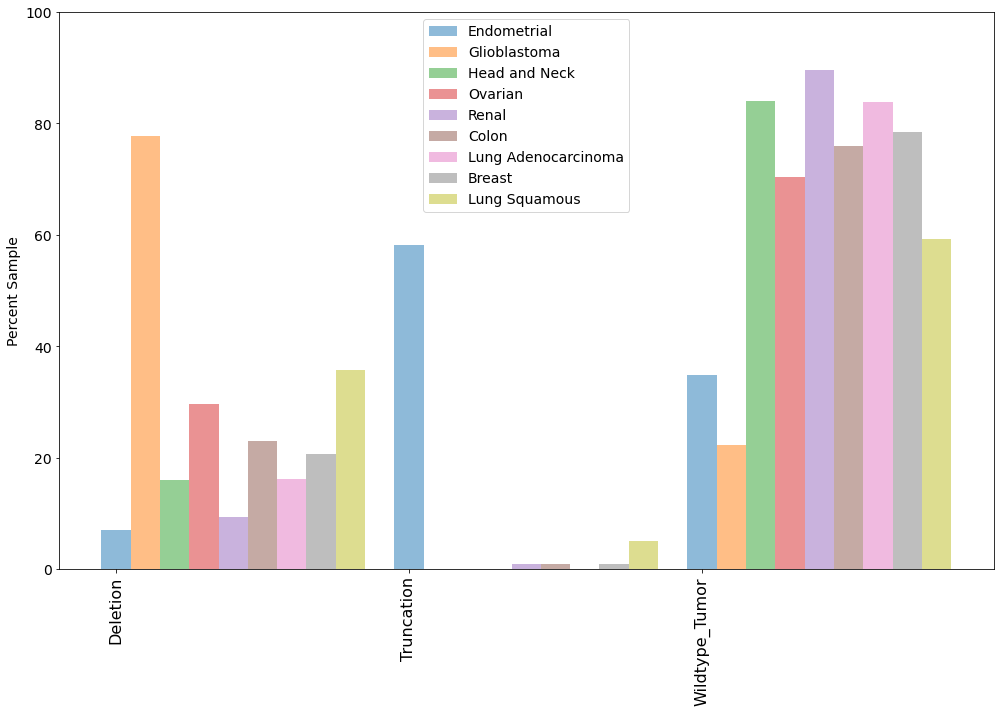

In [21]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', "Colon" ,'Lung Adenocarcinoma', 'Breast',"Lung Squamous"]
figure1_plot_mutations("PTEN",dfs, names, save_to_path = "PTEN_del_only_trunc_only.png")

When a sample has multiple truncations, we catagorized them under truncation.